## 1. Import modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from pprint import pprint

## 2. Create group
We define some gruop $F =\{f_i\}_{i=1}^n$ with cmplement, addition and multlipication table, note that $F$ in not neccesarry a field. we store our data in **Field** class where : 
* $V\in F^n : V_i = f_i  \qquad \forall i=1,2,...,n \qquad$
* $N\in F^n : N_i = \bar{f_i} \qquad \forall i=1,2,...,n$
* $A\in F^{n \times n} : A_i = f_i f_j  \qquad \forall i,j=1,2,...,n$
* $O\in F^{n \times n} : O_i = f_i + f_j  \qquad \forall i,j=1,2,...,n$

where $V$ represent the values, $N$ represent complements (not), $O$ represent addition (or) and $A$ represent multlipication (and). with show table we can see our tables.

In [ ]:
class Field:
    def __init__(self, field_params, name=''):
        self.name = name
        self.VALUES = field_params['values']
        self.NOT_TABLE = field_params['not_table']
        self.ADD_TABLE = field_params['add_table']
        self.MULT_TABLE = field_params['mul_table']

    def __repr__(self):
        return self.name

    def show_tabels(self):
        print(f'{self.name} group properties : \n')
        print(f'Values : {self.VALUES}')
        print(f'Not table : \n{self.NOT_TABLE}\n')
        print(f'Adding table :\n{pd.DataFrame(self.ADD_TABLE)}\n\n')
        print(f'Multiply table :\n{pd.DataFrame(self.MULT_TABLE)}\n\n')
    
    def bit_not(self, a):
        return self.NOT_TABLE[a]

    def bit_and(self, a, b):
        return self.MULT_TABLE[a][b]

    def bit_or(self, a, b):
        return self.ADD_TABLE[a][b]

    def bit_xor(self, a, b):
        val_1 = self.MULT_TABLE[self.NOT_TABLE[a]][b]
        val_2 = self.MULT_TABLE[a][ self.NOT_TABLE[b]]
        return self.ADD_TABLE[val_1][val_2]

    def NOT(self, A):
        return np.array(list(map(self.bit_not, A)))

    def AND(self, *A_list):
        out = A_list[0]
        for A in A_list[1:]:
            out = np.array(list(map(self.bit_and, out, A)))
        return out

    def OR(self, *A_list):
        out = A_list[0]
        for A in A_list[1:]:
            out = np.array(list(map(self.bit_or, out, A)))
        return out

    def XOR(self, *A_list):
        out = A_list[0]
        for A in A_list[1:]:
            out = np.array(list(map(self.bit_xor, out, A)))
        return out

    def NAND(self, *A_list):
        return self.NOT(self.AND(*A_list))

    def NOR(self, *A_list):
        return self.NOT(self.OR(*A_list))

    def XNOR(self, *A_list):
        return self.NOT(self.XOR(*A_list))
    


F_binary = Field(field_params={'values' : [0, 1],
                                'not_table' : [1, 0],
                                'add_table' : [[0, 1], [1, 1]],
                                'mul_table' : [[0, 0], [0, 1]]},
                  name = 'binarry')


F_trinary = Field(field_params={'values' : [0, 1, 2],
                                'not_table' : [2, 1, 0],
                                'add_table' : [[0, 1, 2], [1, 2, 2], [2, 2, 2]],
                                'mul_table' : [[0, 0, 0], [0, 1, 2], [0, 2, 2]]},
                  name = 'trinarry')


F_binary.show_tabels()
F_trinary.show_tabels()

binarry group properties : 

Values : [0, 1]
Not table : 
[1, 0]

Adding table :
   0  1
0  0  1
1  1  1


Multiply table :
   0  1
0  0  0
1  0  1


trinarry group properties : 

Values : [0, 1, 2]
Not table : 
[2, 1, 0]

Adding table :
   0  1  2
0  0  1  2
1  1  2  2
2  2  2  2


Multiply table :
   0  1  2
0  0  0  0
1  0  1  2
2  0  2  2




## 3. Generate data
* **total time** - the total of time wich represent the inputs
* ** resolution** - the length of all the waves.


* **genetare_data(x_values, x_times, resolution)** - genrate wave which chang according to x_values in interval off x_times with respect to resolution, thus the $\frac{e_i^T s}{\textbf{1}^Ts} R $ next values will be $e_i^T x$ where $x$ is **x_values**, $s$ is **x_times** and $R$ is **resolution**.

> for example if we choose $x=[0, 1, 0, 1]$, $s=[0.1, 0.2, 0.3, 0.4]$ and $R=1000$ then the first $100$ values will be $0$, the next $200$ values are $1$, the next $300$ values are $0$ and the last $400$ values are $1$.

* **genetare_clock(repeat, cycles, resolution)** - genrate periodic wave where we repeat over **repeat** pattern for **cycles** number of cycles.

> for example if we choose $repeat=[0, 1]$, $cycles=10$ we get 10 cycles of clock which start at 0, rising to 1, fall to 0 and continue repeat 10 times.

* **delay(A, amount)** - return the delay signal and store the start values as the first value of the input $A$. the total delay is $\frac{aT_0}{R}$ where $a$ is the amount, $T_0$ is total_time and $R$ is the resolution.

> for example if $A=[0, 0, 1, 1, 0, 1, 0, 1, 1]$ and $anount=5$ than the output will be $[0, 0, 0, 0, 0, 0, 0, 1, 1]$ , note that its recomended to choose small value of **amount** (which represent delay in digital circuits) and ensure that we have the first and last **amount** value be 0 to save information.

In [ ]:
def genetare_data(x_values, x_times, resolution):
    data = []
    x_times = x_times.astype(float) /  sum(x_times)
    curr_vals = [0] +  [int(x_times[:i].sum() * resolution) for i in range(1, len(x_times))] + [resolution]
    for i, x in enumerate(x_values):
        data += [x] * (curr_vals[i + 1] - curr_vals[i])
    return np.array(data)

def delay(A, amount=0):
    out = deepcopy(A)
    out[amount:] = out[:len(A) - amount]
    return out

## 4. Implement equential element

create element which genetare the next outpout accornig to its inputs, the clock (not neccesarely) and the previou value **Q_prev**.

4.1 D flip flop (active high) : 

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
D(t) & , c(t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}

4.2 T flip flop (active high) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
Q(t) \oplus T(t) & , c(t) = 1 \\
Q(t) & , else 
\end{array}
\right.
\end{align}


4.3 SR flip flop (active high) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
S(t) + \bar{R}(t) Q(t) & , c(t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}


4.4 JK flip flop (active high) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
J(t) \bar{Q}(t) + \bar{K}(t) Q(t) & , c(t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}


4.5 ABC flip flop (active high with trinnary data) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
\left(C(t) + Q(t) \right) B(t) & , c(t) - c(t - \Delta t) =2 \\
A(t)B(t) & , c(t) - c(t - \Delta t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}



4.6 G flip flop (active high) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
\bar{G}(t) Q(t) & , c(t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}


4.7 A flip flop (active high) :

\begin{align}
Q(t + \Delta t) = \left\{
\begin{array} \\
\bar{A}(t) + \bar{Q}(t) & , c(t) = 1 \\
Q(t) & , else
\end{array}
\right.
\end{align}

In [ ]:
def ABC_ff(A, B, C, Q_full, clock_full, F):
    if clock_full[-1] <= 0:
        return Q_full[-1]
    elif clock_full[-1] == 1:
        return F.bit_and(F.bit_or(C, Q_full[-1]), B)
    else:
        return F.bit_or(A, B)


def get_next(F, E, Q_prev, val):
    res = F.bit_or(F.bit_and(E, val), F.bit_and(F.bit_not(E), Q_prev))
    return F.bit_or(F.bit_and(E, val), F.bit_and(F.bit_not(E), Q_prev))

def D_ff(D, Q_full, clock_full, F):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, D)


def T_latch(T, Q_prev, F):
        return F.bit_xor(T, Q_prev)

def T_ff(T, Q_full, clock_full, F):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, T_latch(T, Q_prev, F))


def G_latch(G, Q_prev, F):
    return F.bit_and(G, F.bit_not(Q_prev))

def G_ff(G, Q_full, clock_full, F):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, G_latch(G, Q_prev, F))


def A_latch(A, Q_prev, F):
    return F.bit_or(F.bit_not(A), F.bit_not(Q_prev))

def A_ff(A, Q_full, clock_full, F):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, A_latch(A, Q_prev, F))


def SR_latch(S, R, Q_prev, F, invalid):
    if invalid == 'set':
        a = 1
    elif invalid == 'reset':
        a = F.bit_not(R)
    elif invalid == 'hold':
        a = F.bit_or(F.bit_not(R), Q_prev)
    elif invalid == 'toggle':
        a = F.bit_not(Q_prev)
    else:
        print('non valid state of invalid')
        a = 0
    return F.bit_or(F.bit_and(F.bit_not(R), Q_prev), F.bit_and(S, a))

def SR_latch_set(S, R, Q_prev, F):
    return SR_latch(S, R, Q_prev, F, invalid='set')

def SR_latch_reset(S, R, Q_prev, F):
    return SR_latch(S, R, Q_prev, F, invalid='reset')

def SR_latch_hold(S, R, Q_prev, F):
    return SR_latch(S, R, Q_prev, F, invalid='hold')

def SR_latch_toggle(S, R, Q_prev, F):
    return SR_latch(S, R, Q_prev, F, invalid='toggle')

def SR_ff(S, R, Q_full, clock_full, F, invalid='set'):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, SR_latch(S, R, Q_prev, F, invalid))


def JK_latch(J, K, Q_prev, F):
    return F.bit_or(F.bit_and(J, F.bit_not(Q_prev)), F.bit_and(F.bit_not(K), Q_prev))

def JK_ff(J, K, Q_full, clock_full, F):
    Q_prev, clock_curr = Q_full[-1], clock_full[-1]
    return get_next(F, clock_curr, Q_prev, JK_latch(J, K, Q_prev, F))


## 5. Apply component.

In [ ]:
def some_component(*inputs, Q_next, field, clock=[], Q_start=0):
    inputs = np.array(inputs).T
    out = np.ones_like(inputs.T[0]) * Q_start
    for i in range(1, len(out)):
        if len(clock):
            out[i] = Q_next(*inputs[i], Q_full=out[:i], clock_full=clock[:i+1], F=field)
        else:
            out[i] = Q_next(*inputs[i], Q_prev=out[i - 1], F=field)
    return out

## 6. arrange and plot results

In [ ]:
def arrange_results(data, attrs):
    return [[dt, att] for dt, att in zip(data, attrs)]

def plot_results(t, results, field, ax, title='\n', lgd_size=14, offset=1):
    curr_offset = 0
    for res, attrs in results:
        ax.plot(t, np.array(res) - curr_offset, **attrs)
        curr_offset += (offset + len(field.NOT_TABLE) - 1)

    y_min = (1 - len(results)) * (len(field.NOT_TABLE) + offset - 1) - 1
    y_max = len(field.NOT_TABLE)
    ax.set_yticks(np.arange(start=y_min + 1, stop=y_max))

    tick_labels = []
    for _ in range(len(results)):
        tick_labels = tick_labels + field.VALUES + [''] * (offset - 1)

    ax.set_yticklabels(tick_labels)
    ax.set_xlim([t[0] + (t[-1] - t[0]) * -0.05, t[-1] + (t[-1] - t[0]) * 0.25])
    ax.set_ylim([y_min, y_max])
    ax.grid(alpha=0.5)
    ax.set_title(title, fontsize=14)
    lgd = ax.legend(fontsize=lgd_size, loc='upper right')

## 7. Simulate some data

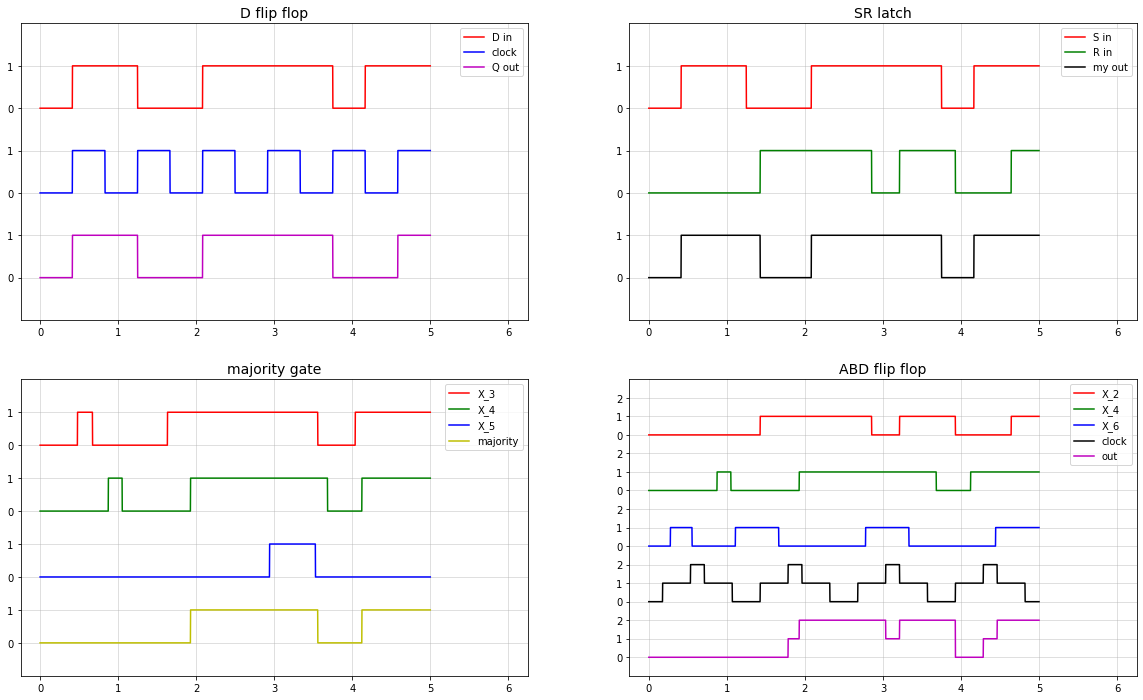

In [ ]:
total_time = 5
resolution = 2000
t = np.linspace(start=0, stop=total_time, num=resolution)

def simulation(inputs, compenent, field, all_attrs, ax, clock=[], text='', lgd_size=12):
    Q_out = some_component(*inputs, Q_next=compenent, field=field, clock=clock, Q_start=0)
    if len(clock):
        out_res_11 = arrange_results(inputs + [clock] + [Q_out], all_attrs)
    else:
        out_res_11 = arrange_results(inputs + [Q_out], all_attrs)
    plot_results(t, out_res_11, field, ax=ax, title=text, lgd_size=lgd_size)

def simulation_gate(inputs, field, all_attrs, ax, text='', lgd_size=12):
    plot_results(t, arrange_results(inputs, all_attrs), field, ax=ax, title=text, lgd_size=lgd_size)

def majority_gate(A, B, C, F):
    return F.OR(F.AND(A, B), F.AND(B, C), F.AND(A, C))

X_1_in = genetare_data(np.array([0, 1, 0, 1, 0, 1]), np.array([0.5, 1, 1, 2, 0.5, 1]), resolution)
X_2_in = genetare_data(np.array([0, 1, 0, 1, 0, 1]), np.array([2, 2, 0.5, 1, 1, 0.5]), resolution)
X_3_in = genetare_data(np.array([0, 1, 0, 1, 0, 1]), np.array([0.5, 0.2, 1, 2, 0.5, 1]), resolution)
X_4_in = genetare_data(np.array([0, 1, 0, 1, 0, 1]), np.array([1, 0.2, 1, 2, 0.5, 1]), resolution)
X_5_in = genetare_data(np.array([0, 1, 0]), np.array([2, 0.4, 1]), resolution)
X_6_in = genetare_data(np.array([0, 1, 0, 1, 0, 1, 0, 1]), np.array([0.5, 0.5, 1, 1, 2, 1, 2, 1]), resolution)

clock_1 = genetare_data(np.array([0, 1] * 6), np.array([1, 1] * 6), resolution)
clock_2 = genetare_data(np.array([0, 1] * 10), np.array([2, 1] * 10), resolution)
clock_3 = genetare_data(np.array([0, 1, 2, 1, 0] * 4), np.array([1, 2, 1, 2, 1] * 4), resolution)


simulation_kwargs = [
                     {'field': F_binary,
                      'inputs': [X_1_in], 
                      'clock': clock_1,
                      'compenent': D_ff,
                      'text': 'D flip flop',
                      'lgd_size': 10,
                      'all_attrs': [{'color': 'r', 'label': 'D in'},
                                    {'color': 'b', 'label': 'clock'},
                                    {'color': 'm', 'label': 'Q out'}]
                      },
                     
                    {'field': F_binary,
                     'inputs': [X_1_in, X_2_in], 
                     'compenent': SR_latch_set,
                     'text': 'SR latch',
                     'lgd_size': 10,
                     'all_attrs': [{'color': 'r', 'label': 'S in'},
                                    {'color': 'g', 'label': 'R in'},
                                    {'color': 'k', 'label': 'my out'}]
                     },
                    {'field': F_binary,
                    'inputs': [X_3_in, X_4_in, X_5_in, majority_gate(X_3_in, X_4_in, X_5_in, F_binary)],
                    'text': 'majority gate',
                    'lgd_size': 10,
                    'all_attrs': [{'color': 'r', 'label': 'X_3'},
                                  {'color': 'g', 'label': 'X_4'},
                                  {'color': 'b', 'label': 'X_5'},
                                  {'color': 'y', 'label': 'majority'}]
                     },
                     {'field': F_trinary,
                      'inputs': [X_2_in, X_4_in, X_6_in],
                      'clock': clock_3,
                      'compenent': ABC_ff,
                      'text': 'ABD flip flop',
                      'lgd_size': 10,
                      'all_attrs': [{'color': 'r', 'label': 'X_2'},
                                    {'color': 'g', 'label': 'X_4'},
                                    {'color': 'b', 'label': 'X_6'},
                                    {'color': 'k', 'label': 'clock'},
                                    {'color': 'm', 'label': 'out'}]
                     }
                     ] 


def set_figure(simulations_list, figsize):
    dim = int(np.ceil(np.sqrt(len(simulation_kwargs))))
    fig, ax = plt.subplots(dim, dim, figsize=figsize)
    for i in range(dim):
        for j in range(dim):
            ax[i, j].set_visible(False)
    return fig, ax, dim

def run_all(simulations_list, figsize=(20, 12)):
    fig, ax, dim = set_figure(simulations_list, figsize)

    for idx, sim in enumerate(simulation_kwargs):
        r, c = idx // dim, idx % dim
        curr_sim = simulation if 'compenent' in sim.keys() else simulation_gate
        if dim == 1:
            ax.set_visible(True)
            curr_sim(**sim, ax=ax)
        else:
            ax[r, c].set_visible(True)
            curr_sim(**sim, ax=ax[r, c])

run_all(simulation_kwargs, figsize=(20, 12))